## Overview

In this notebook, we will practice with image classification using Convoluational Neural Network (CNN). The dataset we will use is `MARCO`(details see https://marco.ccr.buffalo.edu/about). This is a dataset of over 400000 protein crystal images, with four categories: Clear, Crystals, Other, Precipitate. In this session we will use only a small subset of MARCO data, to train a convolutional neural network that can classify the protein crystal images into Clear, Crystals, Other, Precipitate.

## Read in Image Data

In [1]:
from skimage.io import imread
from skimage.io import imsave
import matplotlib.pyplot as plt

Please download the marco.tar.gz file from Canvas and upload it to your current directory.

In [2]:
#unzip the file
! tar -xf ./marco.tar.gz

Read in and diaplay the image:

In [3]:
sample = imread('./marco/Crystal/4885.jpeg')
sample.shape

(300, 300, 3)

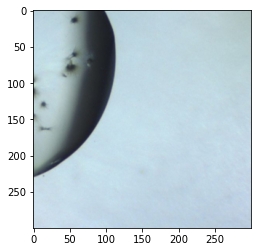

In [4]:
plt.imshow(sample)

## Prepare Training and Validation Data

In [5]:
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#Collect the path of all training images in a list
paths = glob.glob('./marco/Clear/*.jpeg')+glob.glob('./marco/Crystal/*.jpeg')+glob.glob('./marco/Precipitate/*.jpeg')+glob.glob('./marco/Other/*.jpeg')

In [7]:
paths

['./marco/Clear/60980.jpeg',
 './marco/Clear/62410.jpeg',
 './marco/Clear/59979.jpeg',
 './marco/Clear/61001.jpeg',
 './marco/Clear/59923.jpeg',
 './marco/Clear/60542.jpeg',
 './marco/Clear/60142.jpeg',
 './marco/Clear/62462.jpeg',
 './marco/Clear/61513.jpeg',
 './marco/Clear/60089.jpeg',
 './marco/Crystal/5184.jpeg',
 './marco/Crystal/5529.jpeg',
 './marco/Crystal/5542.jpeg',
 './marco/Crystal/5544.jpeg',
 './marco/Crystal/5506.jpeg',
 './marco/Crystal/5553.jpeg',
 './marco/Crystal/5548.jpeg',
 './marco/Crystal/5739.jpeg',
 './marco/Crystal/4885.jpeg',
 './marco/Crystal/4889.jpeg',
 './marco/Precipitate/285.jpeg',
 './marco/Precipitate/323.jpeg',
 './marco/Precipitate/231.jpeg',
 './marco/Precipitate/356.jpeg',
 './marco/Precipitate/340.jpeg',
 './marco/Precipitate/372.jpeg',
 './marco/Precipitate/279.jpeg',
 './marco/Precipitate/242.jpeg',
 './marco/Precipitate/225.jpeg',
 './marco/Precipitate/283.jpeg',
 './marco/Other/179061.jpeg',
 './marco/Other/179060.jpeg',
 './marco/Other/1790

We convert the 4 categories into integers: <br>
0: clear <br>
1: crystal <br>
2: precipitate <br>
3: Other <br>

In [8]:
# Convert the labels into integers
#0: clear
#1: crystal
#2: precipitate
#3: Other
labels = [str(0)]*10+[str(1)]*10+[str(2)]*10+[str(3)]*10

In [9]:
labels

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3']

In [10]:
# split images into training data and validation data
img_train, img_val, label_train, label_val = train_test_split(paths,labels,test_size = 0.3)

In [11]:
# pack the image path and labels in dataframe
df_train = pd.DataFrame(data=list(zip(img_train,label_train)),columns=['path','label'])
df_val = pd.DataFrame(data=list(zip(img_val,label_val)),columns=['path','label'])

In [12]:
df_train.head()

,path,label
0,./marco/Crystal/5553.jpeg,1
1,./marco/Other/179032.jpeg,3
2,./marco/Other/82769.jpeg,3
3,./marco/Clear/60542.jpeg,0
4,./marco/Other/179034.jpeg,3


## Construct Convolutional Neural Network

Here we construct a convolutional neural network by adding a `GlobalAveragePooling2D` layer and a few `Dense`,`Dropout` layers on top of a base model called `DenseNet121`. DenseNet121 is a Dense Convolutional Network with pretrained weights (More details can be found from the paper: https://arxiv.org/abs/1608.06993 )

In [13]:
# parameters 
nclasses = 4
nchannels = 3 #RGB
imagesize=(300,300)
batchsize=2
epochs=5  #how many epochs you want your CNN to be trained

#Load the densenet as a basemodel
basemodel = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False,input_shape=(imagesize[0],imagesize[1],nchannels))
basemodel.trainable = True

#Build CNN
model = tf.keras.Sequential()
model.add(basemodel)
model.add(tf.keras.layers.GlobalAveragePooling2D())  #Join the global average pooling layer
model.add(tf.keras.layers.Dense(512,activation='relu'))  #Add fully connected layer
model.add(tf.keras.layers.Dropout(rate=0.25))  #Add Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dense(128,activation='relu'))  #Add fully connected layer
model.add(tf.keras.layers.Dropout(rate=0.25))  #Add Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dense(nclasses,activation='softmax'))  #Add output layer
model.summary()   #Print each layer parameter information 

2022-12-02 16:50:12.700694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 9, 9, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5

## Image Augmentation

The `ImageDataGenerator` from tensorflow is used to load the image data from the file path we specified, and apply the image augmentation. By image augmentation, we can artifically creates new images through applying operations such as rotation, shift, flip to the original images. 


Here we create two instances of the ImageDataGenerator to generate training data and validation data respectively. In training data generator, we use a set of parameters to define the image augmentation operations. 

In [14]:
# ImageDataGenerator for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=[0.9, 1.2],
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='reflect',
                rescale=1./255
                )

# ImageDataGenerator for validation data
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255
                )


### Exercise 1: Please refer to the documentation of the `ImageDataGenerator` and find the definition of the parameters below:
* rotation_range: rotate the image by some value between 0 and 360 degree. The function will generate the image rotated between +rotation_range and -rotation_range.
* width_shift_range: shift the image in the x direction randomly in left or right. The value is between 0 and 1, which specifies the upper bound of the shift as a fraction of picture width. 
* fill_mode: option to choose to maintain the quality of the image.
* rescale: scale the pixels by multiplying the input value to the pixel values. 

Source: Image Data Augmentation- Image Processing In TensorFlow- Part 2 https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0


The `flow_from_dataframe` method of the ImageDataGenerator will load the images with their labels given in the dataframes we created above. 

In [15]:
train_generator = train_datagen.flow_from_dataframe(
                df_train, #this is the training data
                x_col = 'path',  
                y_col ='label',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = True,
                class_mode='sparse',
                save_to_dir='./marco/augmented',
                save_format='jpeg')

validation_generator = validation_datagen.flow_from_dataframe(
                df_val,  #This is the validation data
                x_col = 'path',  
                y_col ='label',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = False,
                class_mode='sparse')

Found 28 validated image filenames belonging to 4 classes.
Found 12 validated image filenames belonging to 4 classes.


(Important) make sure both the training data and validation data contains all 4 categories of the images.

## Train the model

In [16]:
#Compile model
initial_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Cross entropy loss function
              metrics=["accuracy"]) #Evaluation function

In [17]:
#fit the model
history = model.fit(x=train_generator,   #Enter training set
                    steps_per_epoch=train_generator.n // batchsize, #The number of training steps included in an epoch
                    epochs=epochs, #Training model iterations
                    validation_data=validation_generator,  #Enter validation set
                    validation_steps=validation_generator.n // batchsize, #The number of validation steps included in an epoch
                    )

model.save('./marco/cnn.h5')

Epoch 1/5


2022-12-02 16:50:17.007646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-02 16:50:17.009056: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


14/14 [==============================] - 35s 2s/step - loss: 1.8580 - accuracy: 0.0883 - val_loss: 1.3085 - val_accuracy: 0.3333
Epoch 2/5
14/14 [==============================] - 19s 1s/step - loss: 1.3222 - accuracy: 0.4522 - val_loss: 1.1747 - val_accuracy: 0.5000
Epoch 3/5
14/14 [==============================] - 18s 1s/step - loss: 0.8753 - accuracy: 0.6522 - val_loss: 1.0979 - val_accuracy: 0.5000
Epoch 4/5
14/14 [==============================] - 18s 1s/step - loss: 1.3920 - accuracy: 0.4209 - val_loss: 1.0825 - val_accuracy: 0.5000
Epoch 5/5
14/14 [==============================] - 18s 1s/step - loss: 1.4170 - accuracy: 0.3866 - val_loss: 1.0859 - val_accuracy: 0.4167


In each epoch of the training process, the ImageDataGenerator we created (train_generator) will load the images and perform the augmentation. The model will then be updated (i.e. fitted) based on the augmented images.

### Exercise 2: Plot the augmented image

The augmented images generated during training process are saved under 'marco/augmented'. Please read in one augmented image from the folder and display it.

In [18]:
import glob
from skimage import io
file_list = glob.glob(
    r'./marco/augmented/*.jpeg'
)
print(len(file_list))

284


In [19]:
# Once all the paths are retrieved, read the images one by one in a loop.
img_list = []
for file in file_list:
    im = io.imread(file)
    img_list .append(im)

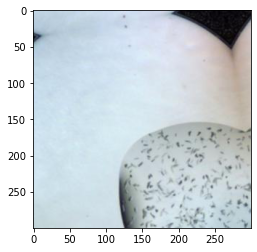

In [21]:
plt.imshow(img_list[0])
plt.show()

Resource:
* Read & write multiple images from a directory in Python (skimage, opencv) https://towardsdev.com/read-write-multiple-images-from-a-directory-in-python-3a0e01e39bc7

## Make Prediction

In this section, we will evaluate the model's performance on the test data (the 20 images in 'marco/testdata' are the test data).

In [22]:
# load the trained model
model = keras.models.load_model('./marco/cnn.h5')

Prepare the test data:

In [23]:
path_test = glob.glob('./marco/testdata/clear/*.jpeg')+glob.glob('./marco/testdata/crystal/*.jpeg')+glob.glob('./marco/testdata/precipitate/*.jpeg')+glob.glob('./marco/testdata/other/*.jpeg')
label_test = [str(0)]*5+[str(1)]*5+[str(2)]*5+[str(3)]*5

#pack the path and label of test images into a dataframe
df_test = pd.DataFrame(data=list(zip(path_test,label_test)),columns=['path','label'])

The test images can still be loaded using the ImageDataGenerator. 

In [24]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255
                )

test_generator = test_datagen.flow_from_dataframe(
                df_test,
                x_col = 'path', 
                y_co = None, #The true label of test data should NOT be input
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = False,
                class_mode=None)

Found 20 validated image filenames.


Then use the model we trained to make prediction on the test images:

In [25]:
predict_result =model.predict(
    test_generator,
    steps=test_generator.n//batchsize,
    workers=8,
    verbose=1)

10/10 [==============================] - 4s 217ms/step


See the predict result for the test images:

In [26]:
predict_result

array([[0.45524615, 0.30141956, 0.06170063, 0.1816336 ],
       [0.6966203 , 0.11575068, 0.09694035, 0.09068867],
       [0.7271432 , 0.10861176, 0.0730142 , 0.09123088],
       [0.6821959 , 0.18324932, 0.10465036, 0.02990447],
       [0.668539  , 0.12145372, 0.06648101, 0.14352624],
       [0.64686745, 0.14112623, 0.06670777, 0.1452985 ],
       [0.64933133, 0.21949778, 0.0639764 , 0.0671945 ],
       [0.59508777, 0.22456867, 0.05312179, 0.12722182],
       [0.58513266, 0.24832445, 0.09521355, 0.07132933],
       [0.6136502 , 0.28067642, 0.05945817, 0.04621527],
       [0.3919096 , 0.25498247, 0.23500907, 0.11809887],
       [0.56211734, 0.19953501, 0.15503953, 0.08330814],
       [0.6734987 , 0.12099503, 0.09413505, 0.1113712 ],
       [0.41722637, 0.30516297, 0.1571721 , 0.12043852],
       [0.47484383, 0.16588995, 0.2488281 , 0.11043808],
       [0.1724968 , 0.33388373, 0.1194346 , 0.3741849 ],
       [0.22704965, 0.28011838, 0.21323714, 0.27959487],
       [0.19064552, 0.28699315,

### Exercise 3: Please get the test accuracy for the above prediction result.

Recall that the output layer of the convolutional neural network has 4 neurons corresponding to the 4 categories we want to classify the data into.  The output value of each neuron will be a number between 0 and 1, which you can interpret as the probability of the corresponding category. The image will be classified into the category with the highest probablity. 

In [27]:
import numpy as np

In [28]:
predict_label =[]
for predict_list in predict_result:
    label = np.argmax(predict_list)
    predict_label.append(str(label))

In [29]:
predict_label 

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '3',
 '1',
 '1',
 '0',
 '3']

In [30]:
predict_label= np.array(predict_label)

In [31]:
predict_label.shape

(20,)

In [32]:
true_label = np.array(df_test['label'].values)

In [33]:
true_label.shape

(20,)

In [34]:
cor_count = 0
for i in range(len(predict_label)):
    if predict_label[i] == true_label[i]:
        cor_count += 1

In [35]:
accuracy = cor_count/len(predict_label)
accuracy

0.35

The model is not that good since it only has 40% accuracy on testing model. Perhaps the training data is not representative of the population of data, i.e. we might need to get more image data to train better model or making more augmented image.